## Demo Notebook: How to calculate the WFE map from a PSD model
This notebook will show you how to calculate a WFE map from PSD model parameters.

**COMMENTS**: 
* This notebook uses the von Karman PSD model. If you have a PSD calculation that is not modeled, you need to model it first.
* A very similar version of this demo notebook is available in POPPY.
* The PSD WFE calculator in this notebook uses a standalone, non-POPPY version. If you need WFE maps scaled to those used in the Fresnel paper, see the demo notebook ``magaox_model_buildWFE.ipynb`` in the ``magaox_poppy`` repository.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits

# import personal code
from model_kit import psd_wfe_poppy
from model_kit import psd_functions as psd

# local helper functions
def act_ap(side, pixscale, radius):
    r_map = psd.build_kmap(side=side, delta_k=pixscale.value)
    circ = r_map < radius.value
    return circ

def rms(opd, pixscale, radius):
    circ = act_ap(opd.shape[0], pixscale, radius)
    return np.sqrt(np.mean(np.square(opd[circ==True].value)))*opd.unit

def pv(opd, pixscale, radius):
    circ = act_ap(opd.shape[0], pixscale, radius)
    data = opd[circ==True].value
    return (np.amax(data) - np.amin(data))*opd.unit

### Example 1: Simple PSD model parameter set
Let's look at a simple PSD model parameter set and the radial distribution.

Text(0.5, 1.0, 'Simple PSD model distribution')

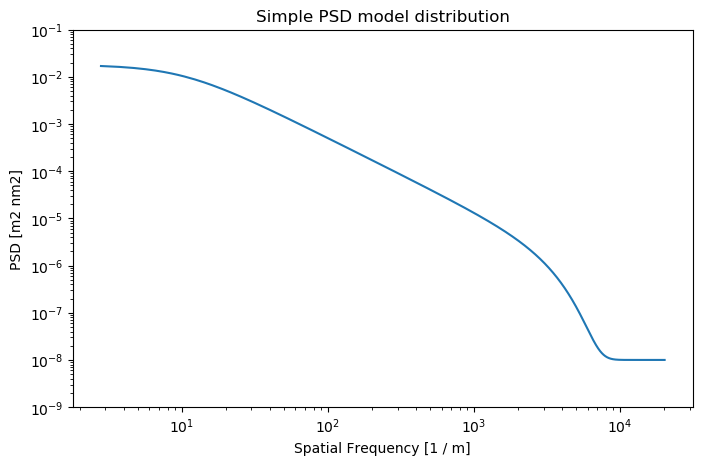

In [2]:
# Unit establishment - the model values provided here are determined by using these units
space_unit = u.m # using meters because POPPY default
surface_unit = u.nm # Adjustable with modeling. But psd_wfe.get_opd() returns in meters.

# Test case parameters
alpha = 1.55
beta = 0.637 * (surface_unit**2) / (space_unit**(alpha-2))
oscl = (0.1*space_unit)
iscl = 0.0003
bsr = 1e-8 * (surface_unit*space_unit)**2 # original test case value is 0, adjusted for demo
parm_test = [[alpha, beta, oscl, iscl, bsr]]
weight_test = [1.0]

# Set up a spatial frequency range. 
# Keep pretty fine spacing to see the lower spatial freq content.
k_range = (np.arange(start=2.8, stop=20176, step=0.95)/space_unit)
psd1 = psd.model_full(k_range, parm_test[0]) 
psd1 = psd1 * weight_test[0]

plt.figure(figsize=[8,5], dpi=100)
plt.loglog(k_range.value, psd1.value)
plt.ylim(top=0.1, bottom=1e-9)
plt.xlabel('Spatial Frequency [{0}]'.format(k_range.unit))
plt.ylabel('PSD [{0}]'.format(psd1.unit))
plt.title('Simple PSD model distribution')

CPU times: user 1.16 s, sys: 156 ms, total: 1.31 s
Wall time: 949 ms


Text(0.5, 1.0, 'PSD OPD, RMS=16.8600 nm, PV=136.69 nm')

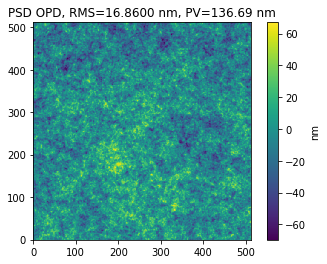

In [3]:
%%time 
# Building the PSD WFE map
seed = 123456
samp = 512
oversamp = 4
pixscale = 5.0544435e-5*u.m
wfe_rms = 8.43*u.nm # paraxial surface rms, will double for reflective OPD

t_opd = psd.make_wfe_map(psd_parameters=parm_test, psd_weight=weight_test,
                           pixscale=pixscale, seed=seed, samp=samp, 
                           oversamp=oversamp, wfe_rms = wfe_rms,
                           apply_reflection=True, map_size='crop')

plt.imshow(t_opd.value, origin='lower')
plt.colorbar().set_label(t_opd.unit)
plt.title('PSD OPD, RMS={0:.4f}, PV={1:.2f}'.format(rms(t_opd, pixscale, samp*pixscale/2), 
                                                    pv(t_opd, pixscale, samp*pixscale/2)))

### Example 2: Combination PSD model parameter set
Let's see how to produce a WFE map for a combination PSD model parameter set.

In [4]:
psd_dict = psd.load_psd_model_fits(fits_filename='data/psd_parms_fm1in.fits',
                                   surf_unit=u.nm, lat_unit=u.m)
psd_dict

{'psd_fm1in': [[0.5686842351535203,
   <Quantity 0.00397526 m(1.4313157648464796) nm2>,
   <Quantity -0.120254 m>,
   0.01306790776799603,
   <Quantity 2.65011818e-15 m2 nm2>],
  [1.051553395979137,
   <Quantity 6.7162836e-05 m(0.948446604020863) nm2>,
   <Quantity -0.09099287 m>,
   0.002507602267429059,
   <Quantity 2.65011818e-17 m2 nm2>],
  [-3.4313629935592354,
   <Quantity 2.88934945e-18 m(5.431362993559235) nm2>,
   <Quantity 0.07689079 m>,
   0.0011599067811798554,
   <Quantity 2.65011818e-17 m2 nm2>],
  [-1.536839100483549,
   <Quantity 2.23884098e-14 m(3.536839100483549) nm2>,
   <Quantity -0.04239405 m>,
   0.00040156830210473016,
   <Quantity 6.78430254e-11 m2 nm2>]],
 'psd_fm1in_weight': [1.0, 1.0, 1.0, 1.0],
 'psd_fm1in_rms': <Quantity 1.95521144 nm>,
 'k_start': <Quantity [  50.0456621 ,  250.2283105 ,  600.54794521, 2402.19178082] 1 / m>,
 'k_end': <Quantity [ 250.2283105 ,  600.54794521, 2402.19178082, 4954.52054795] 1 / m>}

Text(0.5, 1.0, 'Combination PSD model distribution')

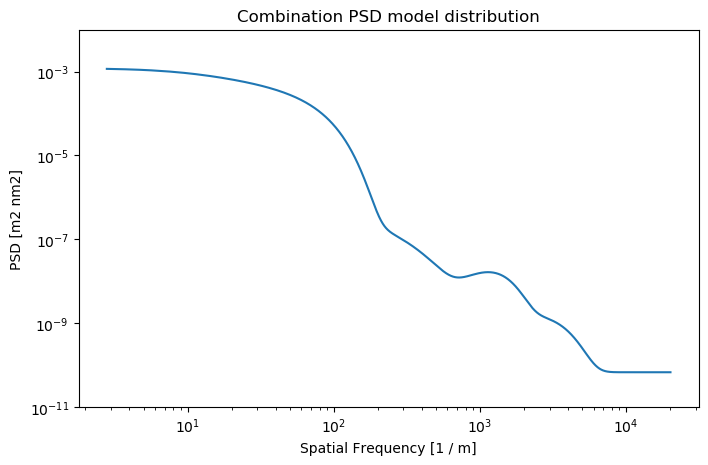

In [5]:
# Set up a spatial frequency range.
k_range = (np.arange(start=2.8, stop=20176, step=0.95)/space_unit)

# combine the PSD models
psd_tot = np.zeros_like(k_range.value)
for n in range(0, len(psd_dict['psd_fm1in_weight'])):
    psd_region = psd.model_full(k_range, psd_dict['psd_fm1in'][n]).value 
    psd_tot += (psd_region * psd_dict['psd_fm1in_weight'][n])
    
# plot
plt.figure(figsize=[8,5], dpi=100)
plt.loglog(k_range.value, psd_tot)
plt.ylim(top=1e-2, bottom=1e-11)
plt.xlabel('Spatial Frequency [{0}]'.format(k_range.unit))
plt.ylabel('PSD [{0}]'.format(str(psd_dict['psd_fm1in'][0][-1].unit)))
plt.title('Combination PSD model distribution')

CPU times: user 4.06 s, sys: 196 ms, total: 4.26 s
Wall time: 3.87 s


Text(0.5, 1.0, 'PSD OPD, RMS=1.7355 nm, PV=10.63 nm')

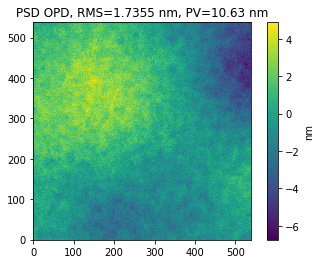

In [15]:
%%time
# Building the PSD WFE map
# Reference case: MagAO-X F-3 1-inch flat mirror
seed = 4936
samp = 538
oversamp = 4
pixscale = 1.6344642e-5*u.m
wfe_rms = 0.8204807*u.nm
beam_diam = samp*pixscale
incident_angle = 19*u.deg

fm_opd = psd.make_wfe_map(psd_parameters=psd_dict['psd_fm1in'], 
                          psd_weight=psd_dict['psd_fm1in_weight'],
                          pixscale=pixscale, 
                          seed=seed, 
                          samp=samp, 
                          oversamp=oversamp, 
                          wfe_rms = wfe_rms,
                          incident_angle=incident_angle,
                          apply_reflection=True, 
                          map_size='crop')


plt.imshow(fm_opd.value, origin='lower')
plt.colorbar().set_label(fm_opd.unit)
plt.title('PSD OPD, RMS={0:.4f}, PV={1:.2f}'.format(rms(fm_opd, pixscale, beam_diam/2), 
                                                    pv(fm_opd, pixscale, beam_diam/2)))

**Note**: the RMS for this example is not double of ``wfe_rms`` declared because there is a ``cos(incident_angle)`` factor that has been incorporated. It worked in the simple example because ``incident_angle = 0``.